In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import os
import seaborn as sns
from scipy import stats

%matplotlib inline

### Read Datasets

In [81]:
path = os.getcwd()
path = os.path.join(path,'dataset')

file_list = glob.glob(path+'/*csv')
names = [text.split("/")[-1].split(".")[0] for text in file_list]

for file,name in zip(file_list,names):
    df = pd.read_csv(file)
    globals()[f'{name}'] = df



### Exploratory Data Analysis (EDA)

Client Data

In [3]:
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [4]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [6]:
client_data.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136,0.097152
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743,0.296175
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000,0.000000
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000,0.000000
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500,0.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000,1.000000


plotting features toward churn to see if the are relationship between features and churn categories

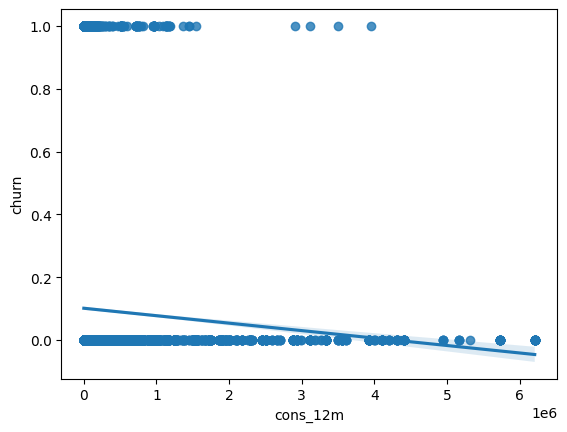

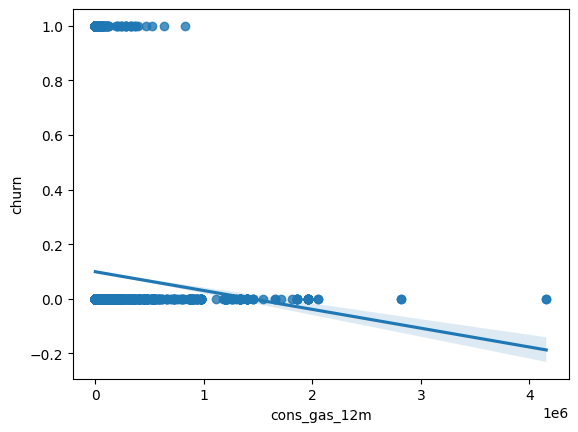

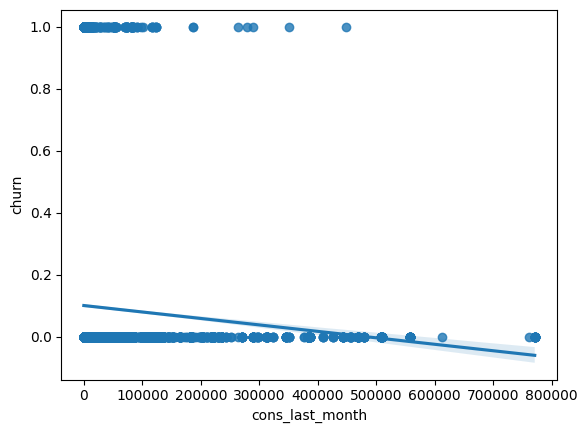

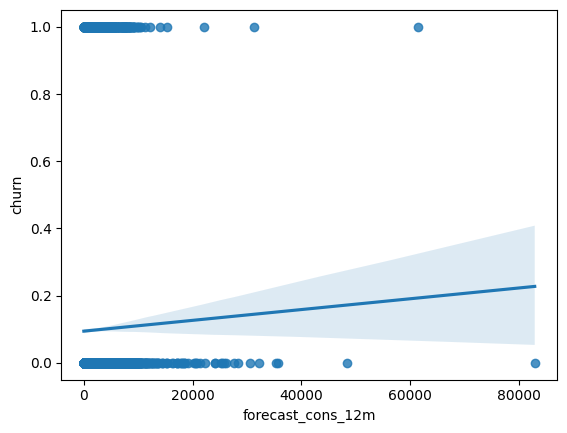

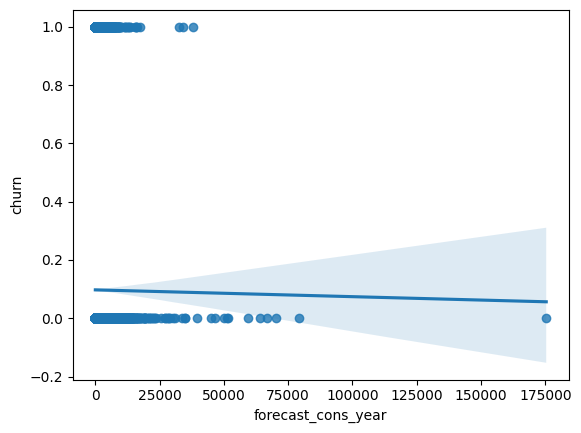

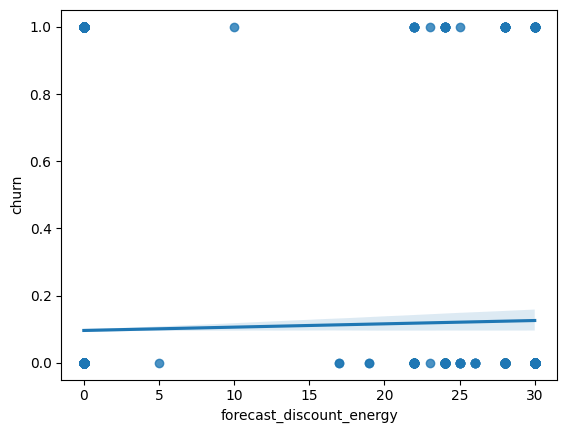

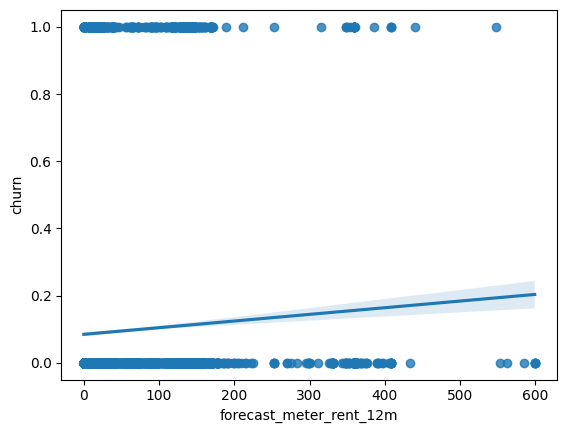

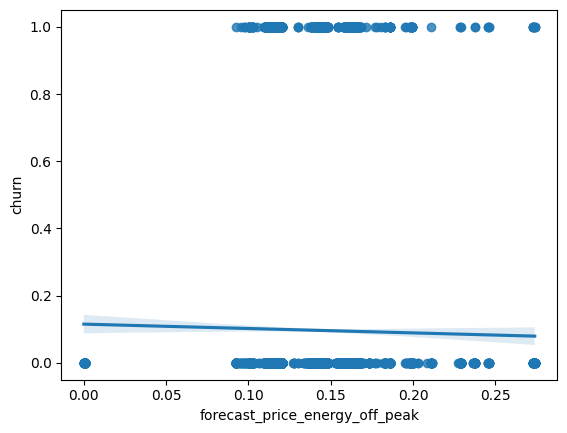

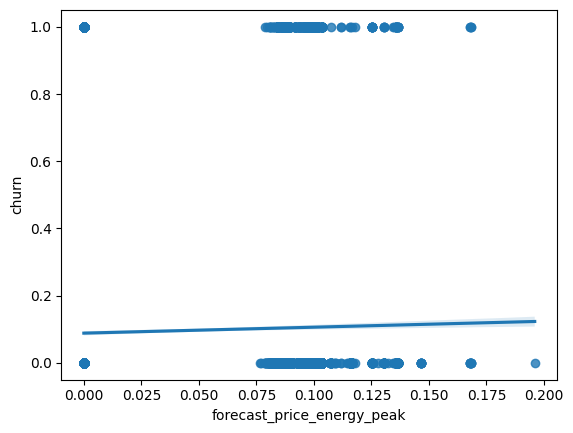

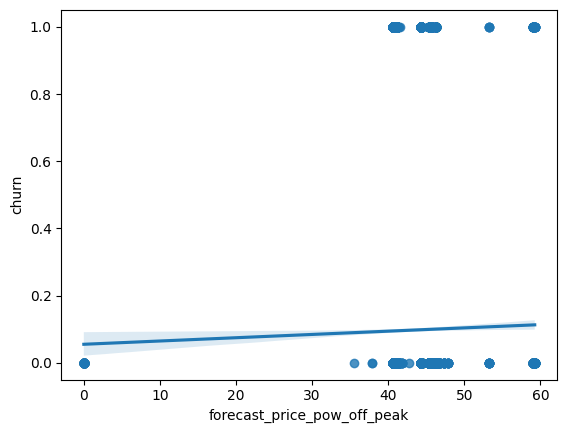

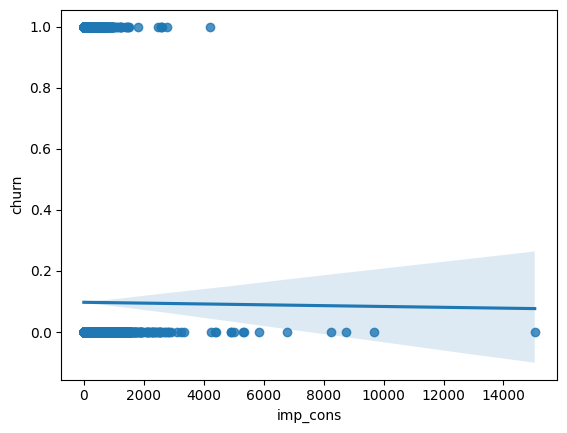

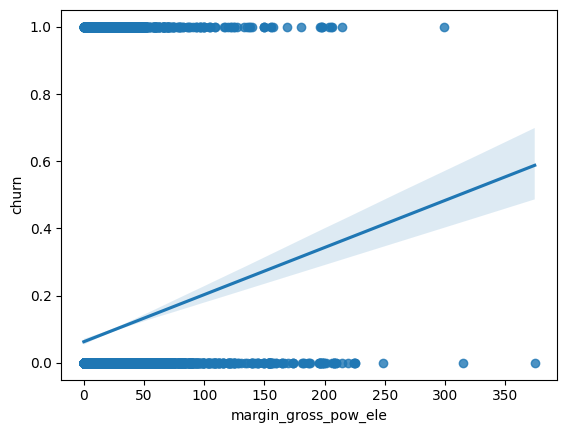

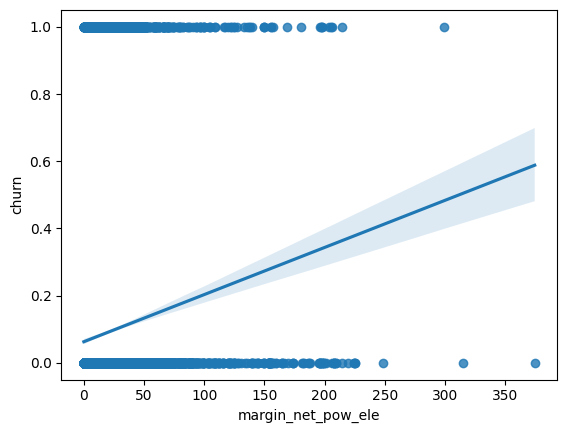

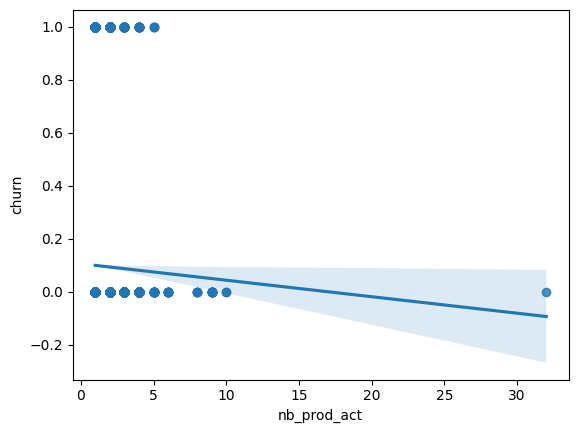

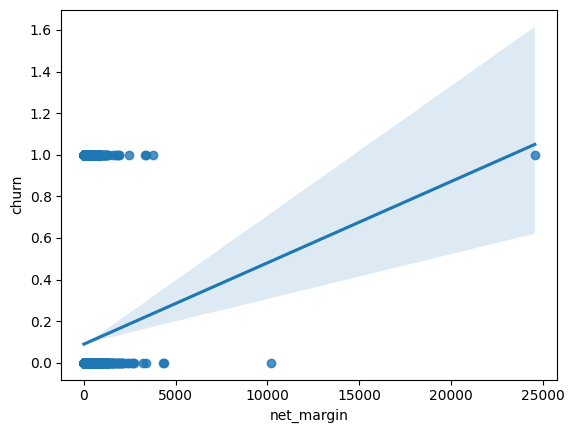

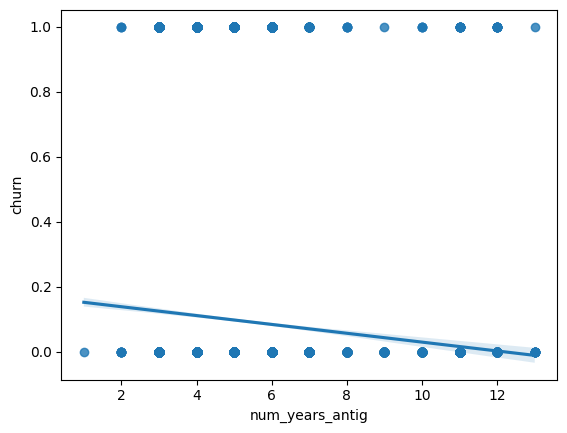

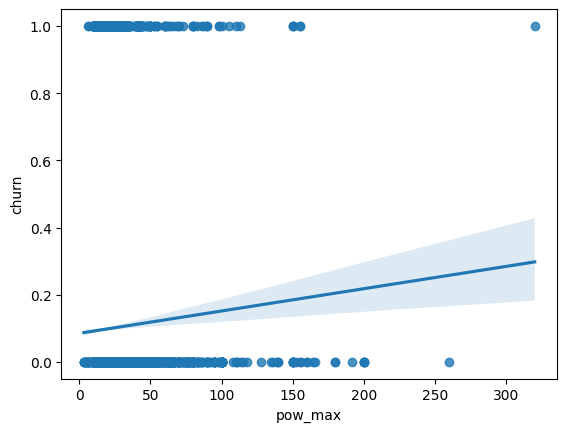

In [7]:
cont_features = client_data.select_dtypes(include=['int64','float64']).columns.tolist()
cont_features.remove("churn")
target = ['churn']

for feature in cont_features:
    sns.regplot(x=client_data[feature], y=client_data["churn"])
    plt.show()

Consumption,power features might have information on customer's churn as it shows a high linear relationship, however further analysis must be taken to ensure its effect to churn. Now let's see the significance of each variable to target (churn and non-churn) using t-test

In [16]:
p_value_list = []
feature_list = []


for feature in cont_features:
    group_churn = client_data[client_data["churn"] == 1][feature].values
    group_non_churn = client_data[client_data["churn"] == 0][feature].values
    print(f"{feature} significance:\n",stats.ttest_ind(a=group_churn,b=group_non_churn))
    statistic,p_value = stats.ttest_ind(a=group_churn,b=group_non_churn)

    p_value_list.append(p_value)
    feature_list.append(feature)

df_p_value = pd.DataFrame()
df_p_value["feature"] = feature_list
df_p_value["p_value"] = p_value_list

sig_feature_client_data = df_p_value[df_p_value["p_value"] < 0.05]["feature"].values.tolist()

print("the significant feature are:",sig_feature_client_data)





cons_12m significance:
 TtestResult(statistic=-5.560953505677991, pvalue=2.7301174281104235e-08, df=14604.0)
cons_gas_12m significance:
 TtestResult(statistic=-4.590267513113454, pvalue=4.463684101402401e-06, df=14604.0)
cons_last_month significance:
 TtestResult(statistic=-5.478091506033441, pvalue=4.370505348809894e-08, df=14604.0)
forecast_cons_12m significance:
 TtestResult(statistic=1.5650088648955298, pvalue=0.11760249762725454, df=14604.0)
forecast_cons_year significance:
 TtestResult(statistic=-0.30907550211952206, pvalue=0.7572685030131331, df=14604.0)
forecast_discount_energy significance:
 TtestResult(statistic=2.057837772550391, pvalue=0.03962341709804149, df=14604.0)
forecast_meter_rent_12m significance:
 TtestResult(statistic=5.352094880594824, pvalue=8.825525348050919e-08, df=14604.0)
forecast_price_energy_off_peak significance:
 TtestResult(statistic=-1.3097132342622824, pvalue=0.1903134672634604, df=14604.0)
forecast_price_energy_peak significance:
 TtestResult(statist

After finding out the significant features that could be used for prediction from the client data, let's explore price data

In [17]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


merging price data with the available customer id

In [21]:
customer_data = client_data[["id","churn"]]
df_price = customer_data.merge(price_data,on="id")

## Analysis

Understanding price distribution

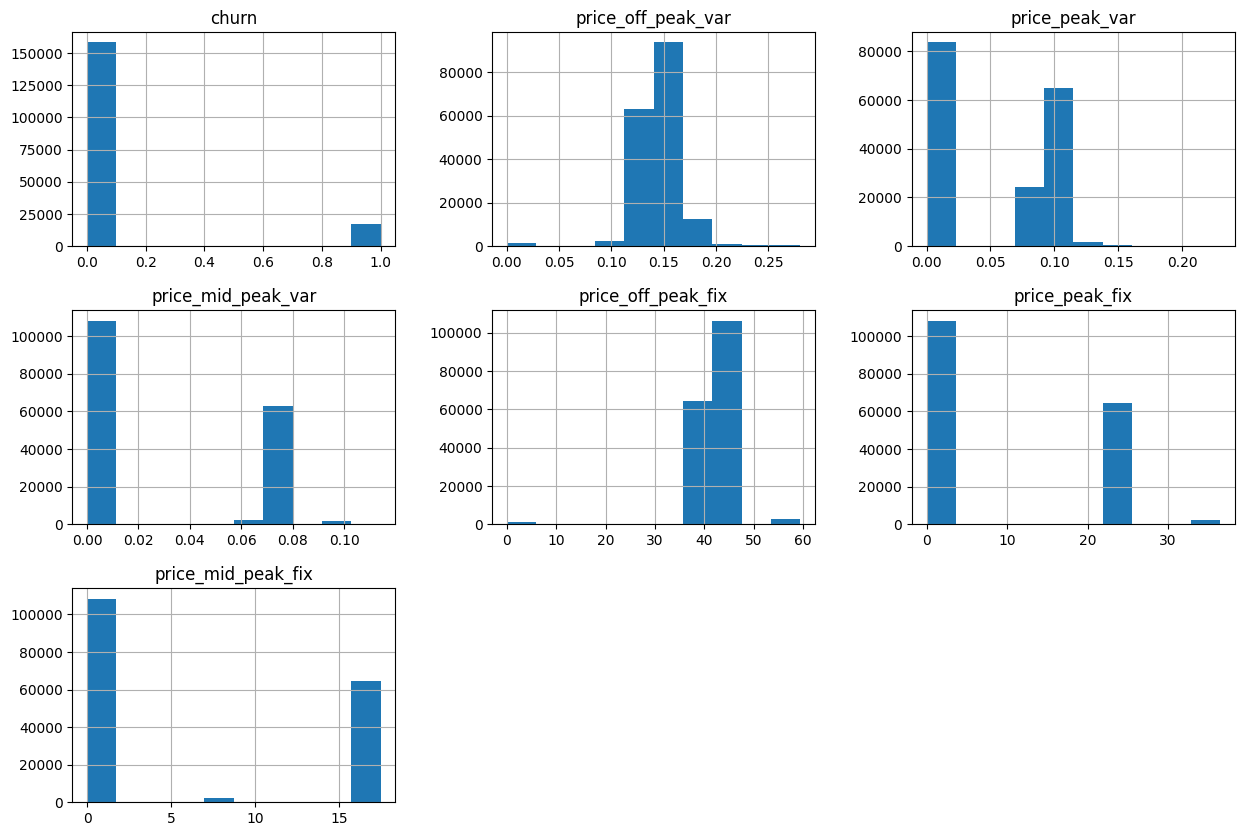

In [22]:
df_price.groupby(['id','price_date']).mean().hist(figsize=(15,10))
plt.show()

Data is skewed and imbalance

### Plotting energy and power price

In [23]:
churn_price = df_price[df_price["churn"] == 1].drop("id",axis=1).groupby(['price_date']).mean()
non_churn_price = df_price[df_price["churn"] == 0].drop("id",axis=1).groupby(['price_date']).mean()


Energy price

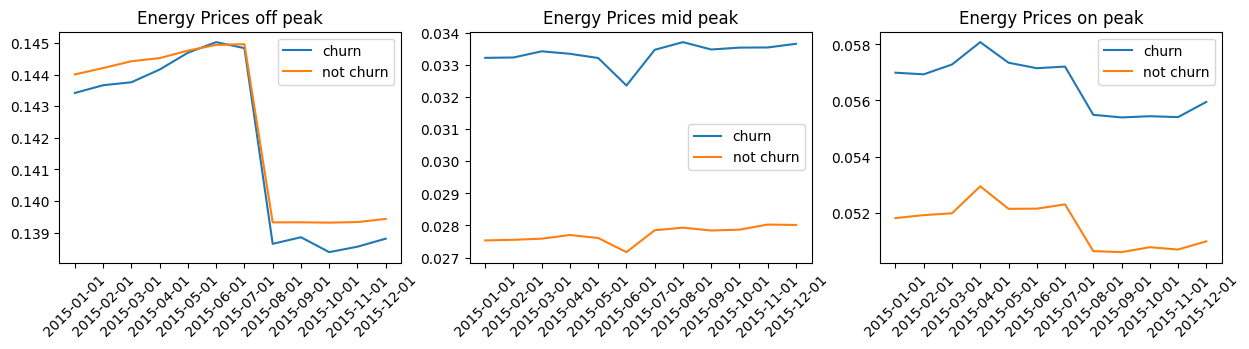

In [24]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.xticks(rotation=45)
plt.plot(churn_price["price_off_peak_var"])
plt.plot(non_churn_price["price_off_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices off peak")
plt.subplot(132)
plt.plot(churn_price["price_mid_peak_var"])
plt.plot(non_churn_price["price_mid_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices mid peak")
plt.subplot(133)
plt.xticks(rotation=45)
plt.plot(churn_price["price_peak_var"])
plt.plot(non_churn_price["price_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices on peak")
plt.show()

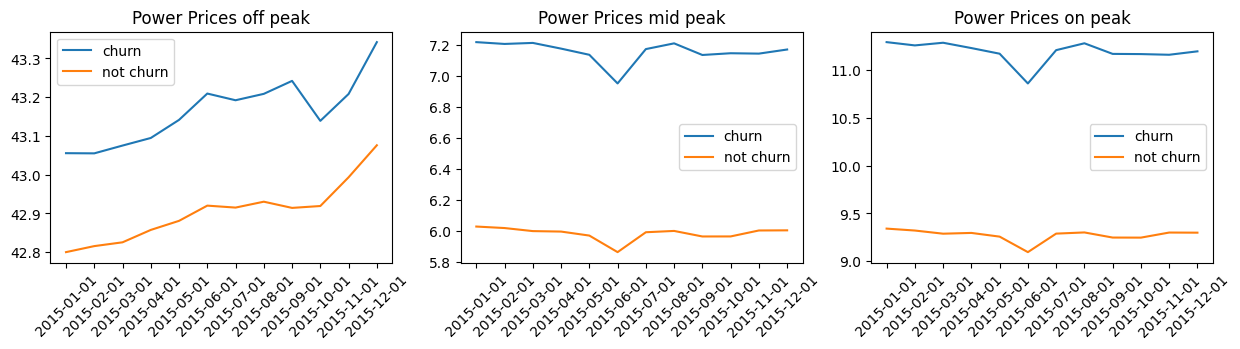

In [25]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.xticks(rotation=45)
plt.plot(churn_price["price_off_peak_fix"])
plt.plot(non_churn_price["price_off_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices off peak")
plt.subplot(132)
plt.plot(churn_price["price_mid_peak_fix"])
plt.plot(non_churn_price["price_mid_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices mid peak")
plt.subplot(133)
plt.xticks(rotation=45)
plt.plot(churn_price["price_peak_fix"])
plt.plot(non_churn_price["price_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices on peak")
plt.show()

Interesting findings on off peak energy prices where churn price is slightly lower than non-churn prices all the year, while on others all churn prices are always higher than non-churn prices. Furthermore, only off peak prices that has high difference between beginning and end of the year, while the others show relatively constant prices throughout the year

let's try to see the correlation coefficient of the features if there is multicollinearity between the features

In [39]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175149 entries, 0 to 175148
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  175149 non-null  object 
 1   churn               175149 non-null  int64  
 2   price_date          175149 non-null  object 
 3   price_off_peak_var  175149 non-null  float64
 4   price_peak_var      175149 non-null  float64
 5   price_mid_peak_var  175149 non-null  float64
 6   price_off_peak_fix  175149 non-null  float64
 7   price_peak_fix      175149 non-null  float64
 8   price_mid_peak_fix  175149 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 12.0+ MB


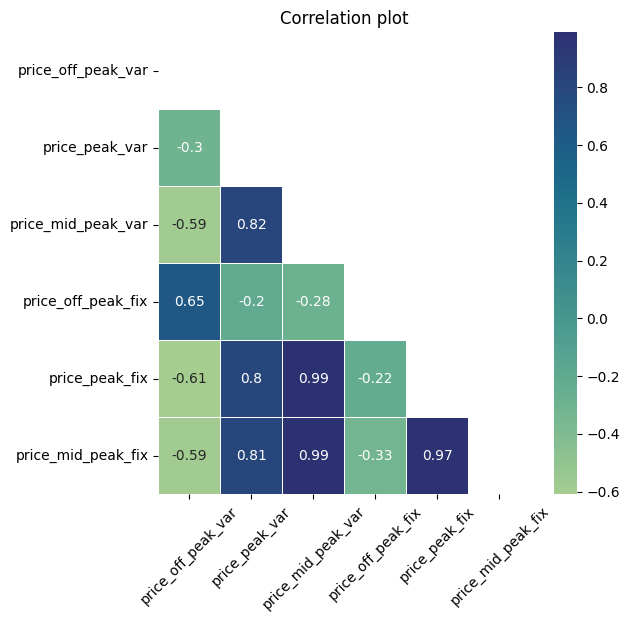

In [47]:
price_corr = df_price.drop(["id","churn","price_date"],axis=1).corr()
plt.figure(figsize=(6,6))
mask = np.triu(np.ones_like(price_corr))
sns.heatmap(price_corr,annot=True,cmap="crest",linewidths=0.5,mask=mask)
plt.xticks(rotation=45)
plt.title("Correlation plot")
plt.show()

High correlation features indicate features having similar information and could cause multicollinearity. It will be better to drop one of the features

## Feature Engineering

Since the price data is monthly, we couldn't directly merge it to the client data. Therefore, we need to transform the information from price data to be derived into yearly format. We can take the average of monthly prices from mid peak and off peak energy and power prices as it follows a linear pattern. The energy off peak was high at the beginning and low at the end of the year thus we can take the price difference as the feature 

In [82]:
#Get jan and dec prices energy off peak
price_off_peak_energy = price_data[["id","price_date","price_off_peak_var"]]
price_off_peak_energy["price_date"] = price_off_peak_energy.price_date.astype("datetime64[ns]")
jan_prices = price_off_peak_energy.groupby("id")[["price_off_peak_var"]].first().reset_index().rename(columns={"price_off_peak_var":"price_off_peak_var_jan"})
dec_prices = price_off_peak_energy.groupby("id")[["price_off_peak_var"]].last().reset_index().rename(columns={"price_off_peak_var":"price_off_peak_var_dec"})

#get the mean price data
price_data.drop(columns=["price_off_peak_var","price_date"],inplace=True)
price_data = price_data.groupby("id").mean().reset_index()

#Calculating energy off peak difference
price_data = price_data.merge(jan_prices,on="id").merge(dec_prices,on="id")
price_data["energy_off_peak_diff"] = price_data["price_off_peak_var_jan"] - price_data["price_off_peak_var_dec"]
price_data.drop(["price_off_peak_var_jan","price_off_peak_var_dec"],axis=1,inplace=True)



/var/folders/g9/8dl_m7ms2gd5gm2zghqh2rl00000gn/T/ipykernel_1288/1606790253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_off_peak_energy["price_date"] = price_off_peak_energy.price_date.astype("datetime64[ns]")


In [83]:
price_data.head()

,id,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,energy_off_peak_diff
0,0002203ffbb812588b632b9e628cc38d,0.103794,0.073160,40.701732,24.421038,16.280694,0.006192
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000,44.385450,0.000000,0.000000,0.004104
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000,45.319710,0.000000,0.000000,-0.050443
3,0010ee3855fdea87602a5b7aba8e42de,0.098292,0.069032,40.647427,24.388455,16.258971,0.010018
4,00114d74e963e47177db89bc70108537,0.000000,0.000000,44.266930,0.000000,0.000000,0.003994
